In [53]:
import os 
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
# Đường dẫn đến thư mục chứa ảnh 
stroke_folder = r"D:\Năm 3 - HK2\Dữ liệu lớn\DeepStroke\data\raw\image_raw\stroke_data"
nostroke_folder = r"D:\Năm 3 - HK2\Dữ liệu lớn\DeepStroke\data\raw\image_raw\noStroke_data"

# Kiểm tra file ảnh có hợp lệ không 
def is_valid_image(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()
        return True
    except:
        return False

# Tiền xử lý ảnh với PIL
def process_image(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        image = image.resize((IMG_SIZE))
        image_array = np.array(image)
        return image_array
    except Exception as e:
        print(f"Không thể xử lý ảnh: {image_path} - {str(e)}")
        return None

# Xử lý ảnh trong thư mục 
def process_images_in_folders():
    images = []
    labels = []
    for label, folder in enumerate([nostroke_folder, stroke_folder]):
        print(f"Đang xử lý folder: {folder}")
        for image_name in os.listdir(folder):
            if not image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            image_path = os.path.join(folder, image_name)
            if not is_valid_image(image_path):
                print(f"File không hợp lệ hoặc bị lỗi: {image_path}")
                continue
            image = process_image(image_path)
            if image is not None:
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)

# Chạy xử lý ảnh 
images, labels = process_images_in_folders()
print(f"Đã nạp được {len(images)} ảnh hợp lệ.")


Đang xử lý folder: D:\Năm 3 - HK2\Dữ liệu lớn\DeepStroke\data\raw\image_raw\noStroke_data
Đang xử lý folder: D:\Năm 3 - HK2\Dữ liệu lớn\DeepStroke\data\raw\image_raw\stroke_data
Đã nạp được 3770 ảnh hợp lệ.


In [54]:
from sklearn.model_selection import train_test_split

# Chia train/test theo tỷ lệ 80/20
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

# Chuẩn hóa ảnh và tạo generator 
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow(
    X_train, y_train,
    batch_size=32,
    shuffle=True
)

val_generator = datagen.flow(
    X_test, y_test,
    batch_size=32,
    shuffle=False
)

# In thông tin tập dữ liệu
print(f"Số ảnh trong tập train: {len(X_train)}")
print(f"Số ảnh trong tập test: {len(X_test)}")


Số ảnh trong tập train: 3016
Số ảnh trong tập test: 754


In [55]:
# Mô hình Custom CNN 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_custom_cnn():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

In [56]:
# Mô hình VGG16

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

def create_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
    base_model.trainable = False  # Freeze weights

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

In [57]:
# Mô hình ResNet 50 

from tensorflow.keras.applications import ResNet50

def create_resnet50_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
    base_model.trainable = False  # Freeze weights

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

In [58]:
# Tạo và compile models 
models = {
    'Custom_CNN': create_custom_cnn(),
    'VGG16': create_vgg16_model(),
    'ResNet50': create_resnet50_model()
}

# Compile model
for name, model in models.items():
    print(f"Compiling {name} ...")
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

c:\Users\QUYEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compiling Custom_CNN ...
Compiling VGG16 ...
Compiling ResNet50 ...


In [59]:
# Train model
histories = {}

for name, model in models.items():
    print(f"Training {name} ...")
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator
    )
    histories[name] = history

Training Custom_CNN ...
Epoch 1/10


c:\Users\QUYEN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


95/95 ━━━━━━━━━━━━━━━━━━━━ 36s 362ms/step - accuracy: 0.6674 - loss: 0.9008 - val_accuracy: 0.7971 - val_loss: 0.4791
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 32s 339ms/step - accuracy: 0.8082 - loss: 0.4111 - val_accuracy: 0.8926 - val_loss: 0.2598
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 31s 327ms/step - accuracy: 0.9091 - loss: 0.2346 - val_accuracy: 0.8660 - val_loss: 0.3388
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 32s 336ms/step - accuracy: 0.9309 - loss: 0.1818 - val_accuracy: 0.9231 - val_loss: 0.2083
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 33s 349ms/step - accuracy: 0.9721 - loss: 0.0815 - val_accuracy: 0.9284 - val_loss: 0.1882
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 31s 327ms/step - accuracy: 0.9819 - loss: 0.0585 - val_accuracy: 0.9324 - val_loss: 0.2378
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 32s 334ms/step - accuracy: 0.9827 - loss: 0.0523 - val_accuracy: 0.8992 - val_loss: 0.2927
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 33s 347ms/step - accuracy: 0.9885 - loss: 0.0471 - val_accuracy: 0.940

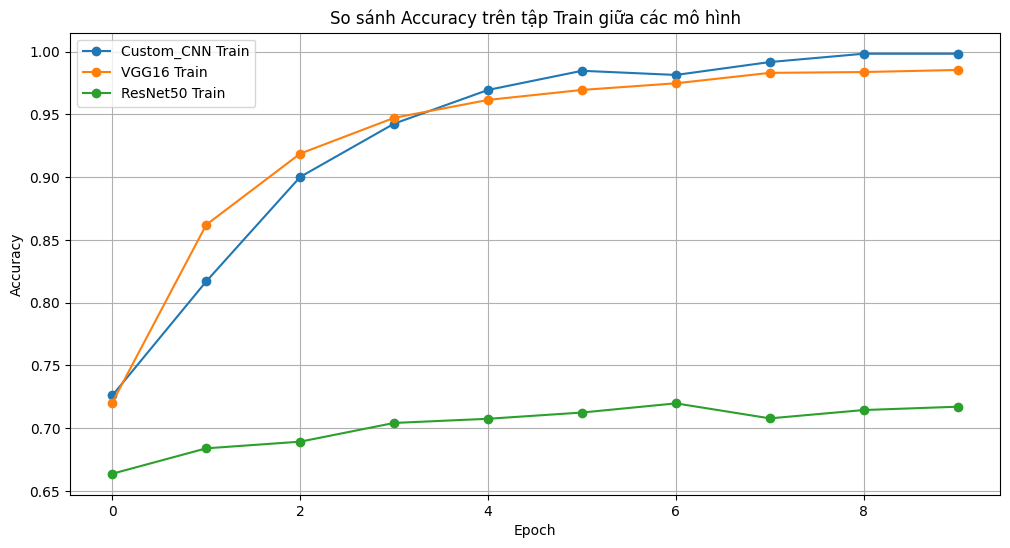

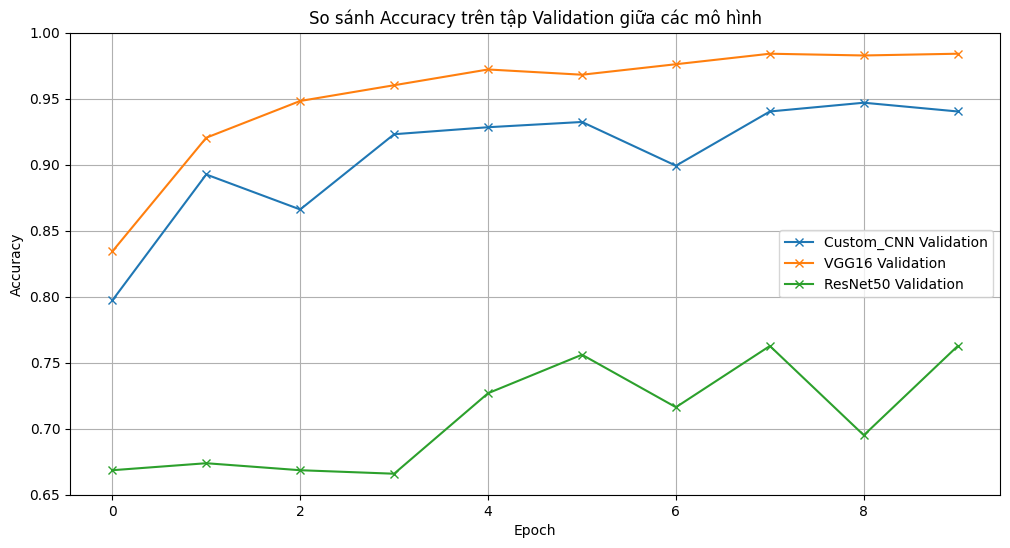

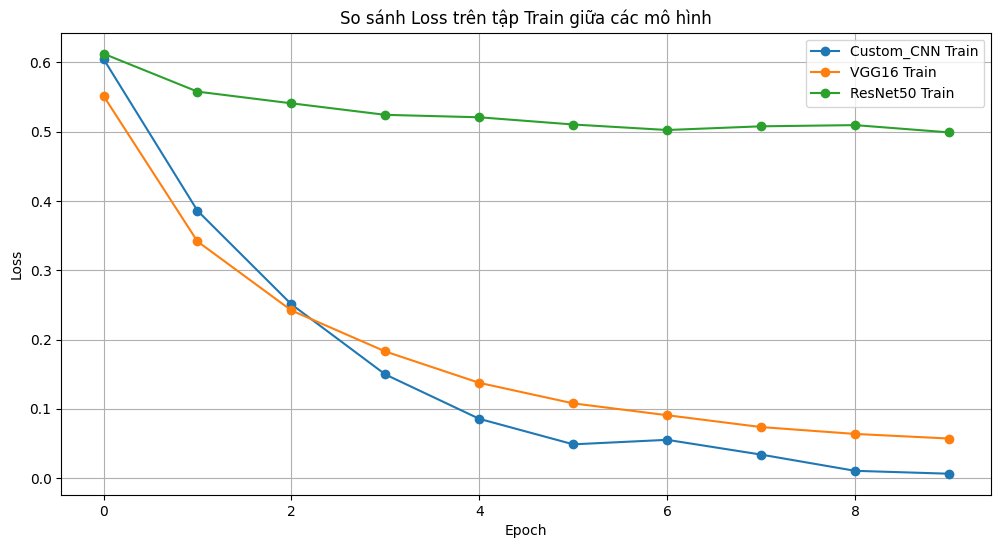

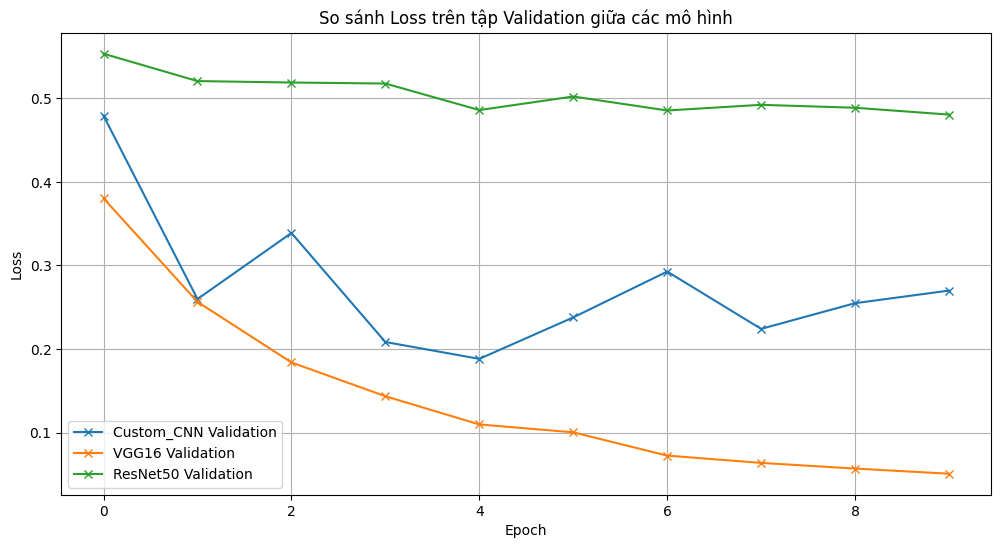

In [60]:
import matplotlib.pyplot as plt

def plot_metrics_combined(histories, metric):
    plt.figure(figsize=(12, 6))
    
    # Vẽ biểu đồ Training
    for name, history in histories.items():
        plt.plot(history.history[metric], label=f'{name} Train', marker='o')
    
    plt.title(f'So sánh {metric.capitalize()} trên tập Train giữa các mô hình')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 6))
    
    # Vẽ biểu đồ Validation
    for name, history in histories.items():
        plt.plot(history.history[f'val_{metric}'], label=f'{name} Validation', marker='x')
    
    plt.title(f'So sánh {metric.capitalize()} trên tập Validation giữa các mô hình')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# Vẽ biểu đồ Accuracy cho tất cả mô hình
plot_metrics_combined(histories, 'accuracy')

# Vẽ biểu đồ Loss cho tất cả mô hình
plot_metrics_combined(histories, 'loss')


In [61]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Hàm đánh giá mô hình
def evaluate_model(model, val_generator, model_name):
    # Reset generator trước khi dự đoán
    val_generator.reset()
    
    # Dự đoán
    Y_pred = model.predict(val_generator, verbose=1)
    y_pred = (Y_pred > 0.5).astype(int).reshape(-1)  # Chuyển dự đoán thành nhị phân 0 hoặc 1
    
    # Lấy nhãn thực tế từ generator (batch đầu tiên)
    y_true = []
    for i in range(len(val_generator)):
        # Lấy nhãn từ batch và append vào list
        _, y_batch = val_generator[i]
        y_true.append(y_batch)
    
    # Chuyển y_true thành mảng 1D
    y_true = np.concatenate(y_true, axis=0)
    
    # Ma trận nhầm lẫn
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Stroke', 'Stroke'], yticklabels=['Non-Stroke', 'Stroke'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    # Báo cáo phân loại
    print(f"Classification Report for {model_name}:")
    report = classification_report(y_true, y_pred, target_names=['Non-Stroke', 'Stroke'], output_dict=True)
    print(classification_report(y_true, y_pred, target_names=['Non-Stroke', 'Stroke']))


Đánh giá mô hình Custom_CNN ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step


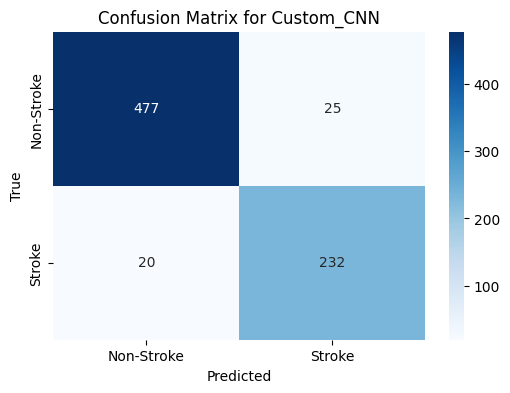

Classification Report for Custom_CNN:
              precision    recall  f1-score   support

  Non-Stroke       0.96      0.95      0.95       502
      Stroke       0.90      0.92      0.91       252

    accuracy                           0.94       754
   macro avg       0.93      0.94      0.93       754
weighted avg       0.94      0.94      0.94       754

Đánh giá mô hình VGG16 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step


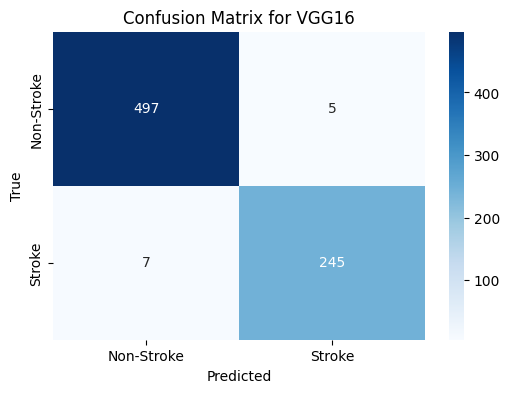

Classification Report for VGG16:
              precision    recall  f1-score   support

  Non-Stroke       0.99      0.99      0.99       502
      Stroke       0.98      0.97      0.98       252

    accuracy                           0.98       754
   macro avg       0.98      0.98      0.98       754
weighted avg       0.98      0.98      0.98       754

Đánh giá mô hình ResNet50 ...
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 945ms/step


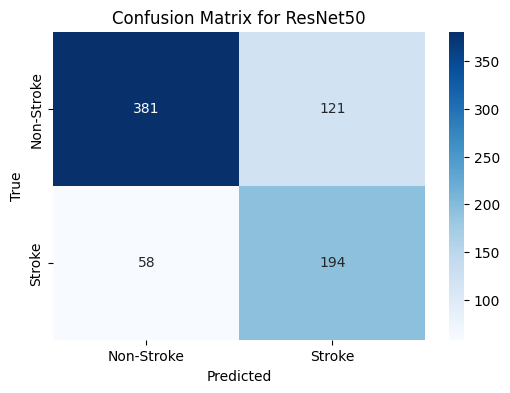

Classification Report for ResNet50:
              precision    recall  f1-score   support

  Non-Stroke       0.87      0.76      0.81       502
      Stroke       0.62      0.77      0.68       252

    accuracy                           0.76       754
   macro avg       0.74      0.76      0.75       754
weighted avg       0.78      0.76      0.77       754



In [62]:
for name, model in models.items():
    print(f"Đánh giá mô hình {name} ...")
    evaluate_model(model, val_generator, name)

In [ ]:
metrics_df = pd.DataFrame(model_metrics).T  
print(metrics_df)

            Precision    Recall  F1-Score  Accuracy
Custom_CNN   0.857877  0.998008  0.922652  0.888594
VGG16        0.978474  0.996016  0.987167  0.982759
ResNet50     0.848421  0.802789  0.824974  0.773210


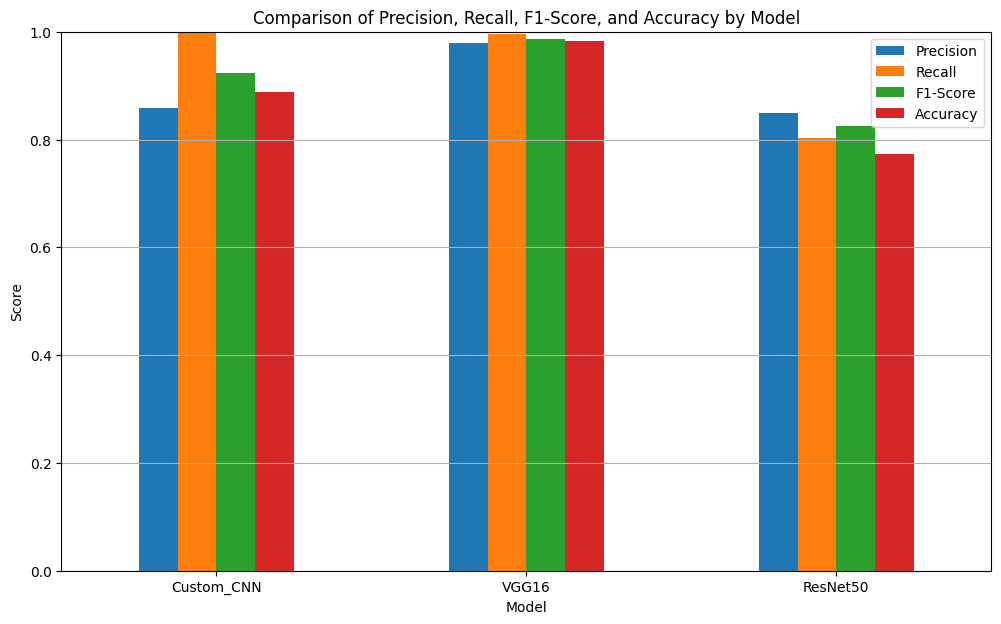

In [64]:
# Vẽ biểu đồ dạng cột (bar chart)
metrics_df.plot(kind='bar', figsize=(12, 7))

# Chỉnh sửa biểu đồ
plt.title('Comparison of Precision, Recall, F1-Score, and Accuracy by Model')  # Tiêu đề biểu đồ
plt.xlabel('Model')  # Nhãn trục x là tên mô hình
plt.ylabel('Score')  # Nhãn trục y là điểm số
plt.ylim(0, 1)  # Giới hạn trục y từ 0 đến 1 (vì các chỉ số này thường có giá trị từ 0 đến 1)
plt.xticks(rotation=0)  # Ghi chú trên trục x được hiển thị ngang
plt.legend(loc='upper right')  # Đặt chú thích ở góc trên bên phải
plt.grid(axis='y')  # Hiển thị lưới trên trục y
plt.show()  # Hiển thị biểu đồ

In [65]:
metrics_melted = pd.DataFrame(metrics_df).T  
print(metrics_melted)

           Custom_CNN     VGG16  ResNet50
Precision    0.857877  0.978474  0.848421
Recall       0.998008  0.996016  0.802789
F1-Score     0.922652  0.987167  0.824974
Accuracy     0.888594  0.982759  0.773210


       Metric       Model  Score
0   Precision  Custom_CNN   0.85
1      Recall  Custom_CNN   0.80
2    F1-Score  Custom_CNN   0.82
3    Accuracy  Custom_CNN   0.88
4   Precision       VGG16   0.90
5      Recall       VGG16   0.87
6    F1-Score       VGG16   0.89
7    Accuracy       VGG16   0.91
8   Precision    ResNet50   0.93
9      Recall    ResNet50   0.89
10   F1-Score    ResNet50   0.91
11   Accuracy    ResNet50   0.92


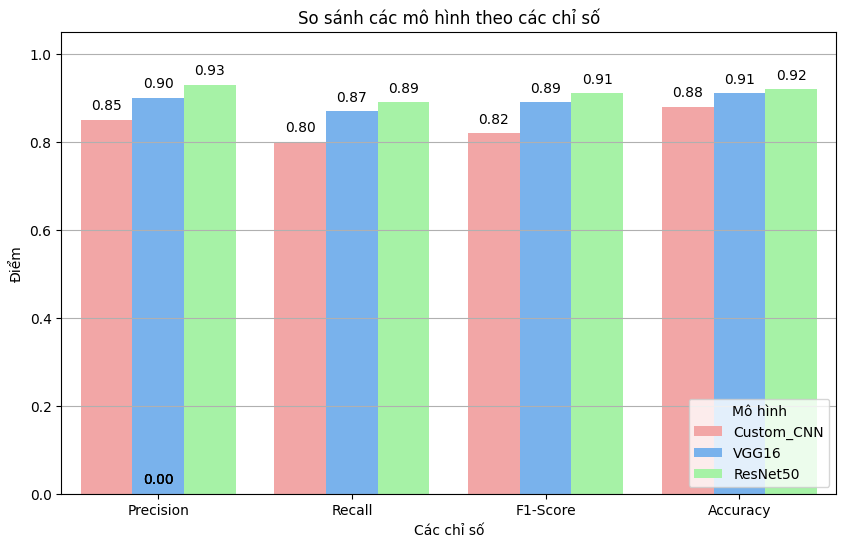

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Giả sử metrics_df là DataFrame chứa các chỉ số của các mô hình
# Dữ liệu mẫu của metrics_df
metrics_df = pd.DataFrame({
    'Custom_CNN': [0.85, 0.80, 0.82, 0.88],
    'VGG16': [0.90, 0.87, 0.89, 0.91],
    'ResNet50': [0.93, 0.89, 0.91, 0.92]
}, index=['Precision', 'Recall', 'F1-Score', 'Accuracy'])

# Chuyển metrics_df thành dạng long format
metrics_melted = metrics_df.reset_index().melt(id_vars=['index'], var_name='Model', value_name='Score')
metrics_melted.rename(columns={'index': 'Metric'}, inplace=True)

# Kiểm tra lại cấu trúc của metrics_melted
print(metrics_melted)

# Định nghĩa màu sắc (custom palette)
custom_palette = {
    'Custom_CNN': '#FF9999',  # Màu đỏ nhạt
    'VGG16': '#66B2FF',      # Màu xanh dương
    'ResNet50': '#99FF99'    # Màu xanh lá cây nhạt
}

# Vẽ đồ thị với Metrics là trục x
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=metrics_melted,
    x='Metric',
    y='Score',
    hue='Model',
    palette=custom_palette
)

# Thêm giá trị lên các cột (labels)
for p in barplot.patches:
    barplot.annotate(
        format(p.get_height(), '.2f'),  # Cắt bỏ thập phân 2 chữ số
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),  # Khoảng cách từ cột
        textcoords='offset points'
    )

# Tùy chỉnh đồ thị
plt.title('So sánh các mô hình theo các chỉ số')
plt.ylim(0, 1.05)  # Tăng một chút ở phần trên
plt.ylabel('Điểm')
plt.xlabel('Các chỉ số')
plt.legend(title='Mô hình', loc='lower right')
plt.grid(axis='y')

# Hiển thị đồ thị
plt.show()


In [67]:
#Lưu mô hình sau khi huấn luyện 
model.save(r'D:\Năm 3 - HK2\Dữ liệu lớn\DeepStroke\backend\models\vgg16_model.h5')